## Cognition and Computation Project
Mario Alejandro Tapia Montero\
2081407\
05/02/2024

### Introduction
In this project, an exploration of Deep Belief Networks (DBNs) is conducted using the Fashion MNIST dataset. The objective is to investigate various aspects of DBNs, including understanding their internal mechanisms and assessing their robustness against adversarial attacks. Through tasks such as visualizing receptive fields, clustering internal representations, evaluating linear read-out capabilities, and analyzing robustness to noise and adversarial attacks, insights into DBNs' performance is sought

### Importing required scripts and dataset

We start by importing the DBN and RBM scripts, and the required libraries

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
from torch.utils.data import random_split
import torch.nn.functional as functional
from tqdm.notebook import tqdm
from DBN import DBN
from sklearn.metrics import confusion_matrix
import seaborn as sns

Here, it is possible to choose dynamically the kind of device used for computations (CPU or GPU).

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


For this project, the FashionMNIST dataset is used. Here, the train and test sets are downloaded

In [5]:
%%capture
fmnist_tr = tv.datasets.FashionMNIST(root="../fashionmnist", train=True, download=True)
fmnist_te = tv.datasets.FashionMNIST(root="../fashionmnist", train=False, download=True)

Each class is represented by a number:
- 0 : T-shirt/top
- 1 : Trouser
- 2 : Pullover
- 3 : Dress
- 4 : Coat
- 5 : Sandal
- 6 : Shirt
- 7 : Sneaker
- 8 : Bag
- 9 : Ankle boot

We normalize by dividing each pixel by the maximum value (255 in RGB notation) to obtain input values encoded between 0 and 1, as needed by DBNs to work

In [6]:
fmnist_tr.data = fmnist_tr.data / 255   # Deep Belief Network work with values between 0 and 1. In this
fmnist_te.data = fmnist_te.data / 255

If using CUDA, we transfer the data to the GPU.

In [7]:
fmnist_tr.data = fmnist_tr.data.to(device)
fmnist_te.data = fmnist_te.data.to(device)
fmnist_tr.targets = fmnist_tr.targets.to(device)
fmnist_te.targets = fmnist_te.targets.to(device)

Let's visualize one training image (a T-shirt/top class):

The image shows the type of clothes: 0


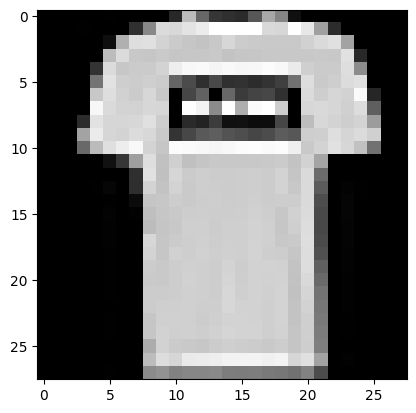

In [27]:
idx = 1
img = fmnist_tr.data[idx].cpu()  # to plot the data, we need to move it back from the GPU memory
print("The image shows the type of clothes: {}".format(fmnist_tr.targets[idx]) )
plt.imshow(img, cmap = 'gray')
plt.show()

### Initializing DBN
When applying the neural network model to the task of classifying clothes, I decided to increase the complexity of the model to capture the diversity and richness of the clothing features. One way to do this is to add more neurons to the hidden layers of the network. By having more neurons, we allow the network to learn more complex features that can distinguish different types of clothes. This is different from the scenario that we encountered in the labs, where we used a simpler network with fewer neurons in the hidden layers, because the data we worked with was less complex and varied. Another way of doing this is by increasing the number of hidden layers.

In [12]:
dbn_fmnist = DBN(visible_units=28*28,          # dimensionality of the sensory data (28 by 28 pixels)
                hidden_units=[400, 800, 1200], # size of hidden layers
                k=1,                          # reconstruction n° of steps in Contrastive Divergence
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,  # For increasing number of reconstruction steps in Contrastive Divergence
                use_gpu=torch.cuda.is_available())

### Training phase
To improve the performance of the model, the number of epochs are increased from 50 (as shown in the original labs) to 150. Beyond 150 epochs, the error does not decrease significantly, which indicates that the model has reached its optimal point and further training may lead to overfitting. This also affects the computation time, which increases with more epochs.

In [13]:
num_epochs = 150
batch_size = 125

dbn_fmnist.train_static(
    fmnist_tr.data,
    fmnist_tr.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8736     |0.0844       |318.3900   |7.4317     |
|20    |1.7535     |0.0779       |304.6612   |5.8336     |
|30    |1.7225     |0.0782       |302.2087   |5.4104     |
|40    |1.7000     |0.0757       |293.4550   |5.4892     |
|50    |1.6958     |0.0766       |292.4133   |4.5427     |
|60    |1.6914     |0.0767       |291.4011   |5.2428     |
|70    |1.6853     |0.0772       |290.8568   |5.2346     |
|80    |1.6804     |0.0768       |284.4654   |5.5460     |
|90    |1.6836     |0.0770       |284.2441   |5.1354     |
|100    |1.6766     |0.0766       |283.8931   |4.4429     |
|110    |1.6783     |0.0770       |284.9438   |5.4774     |
|120    |1.6754     |0.0772       |282.2752   |5.4964     |
|130    |1.6807     |0.0770       |280.5584   |6.2020     |
|140    |1.6736     |0.0765       |277.4600   |5.0508     |
|150    |1.6802     |0.0786       |279.1560   |6.1778     |
---------

### Visualizing receptive fields

A receptive field refers to the region in the input space that a particular neuron is "looking" at. It is a useful concept to understand what the nodes are doing and how the network is behaving. By examining the receptive fields, we can gain insights into the features that the neurons are detecting and the patterns that they are learning.



In [14]:
def get_weights(dbn, layer):    # Takes the weights from each layer of the RBM
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):  # Used to visualize the most representative weights of the receptive field
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights): # How many receptive fields we want to plot
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot. The 28x28 is the size of the original images

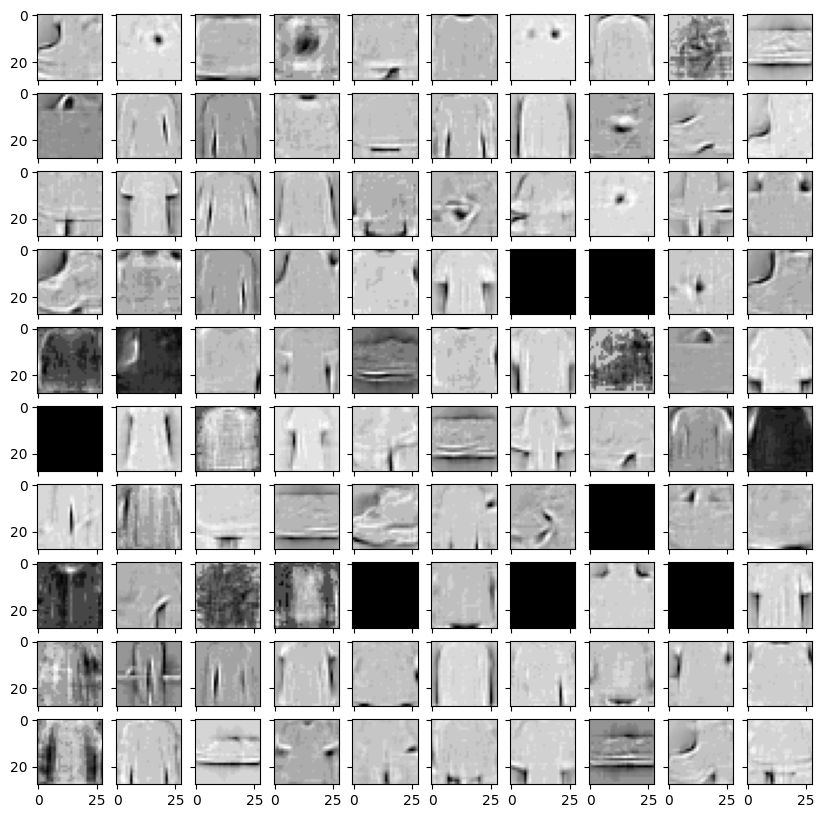

In [15]:
w1 = get_weights(dbn_fmnist, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

The weights in the second and third hidden layers have don't have the same dimensionality as MNIST digits, therefore, we will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images.

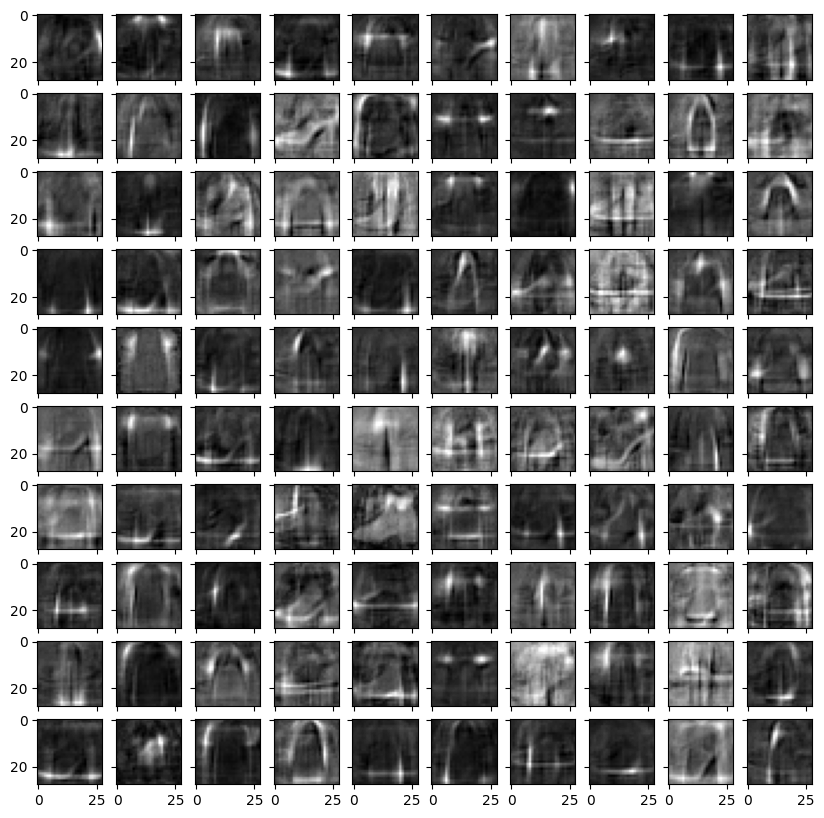

In [16]:
# Plot the receptive field of the second hidden layer:
w1 = get_weights(dbn_fmnist, layer=0) # First hidden layer weights
w2 = get_weights(dbn_fmnist, layer=1) # Second hidden layer weights

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

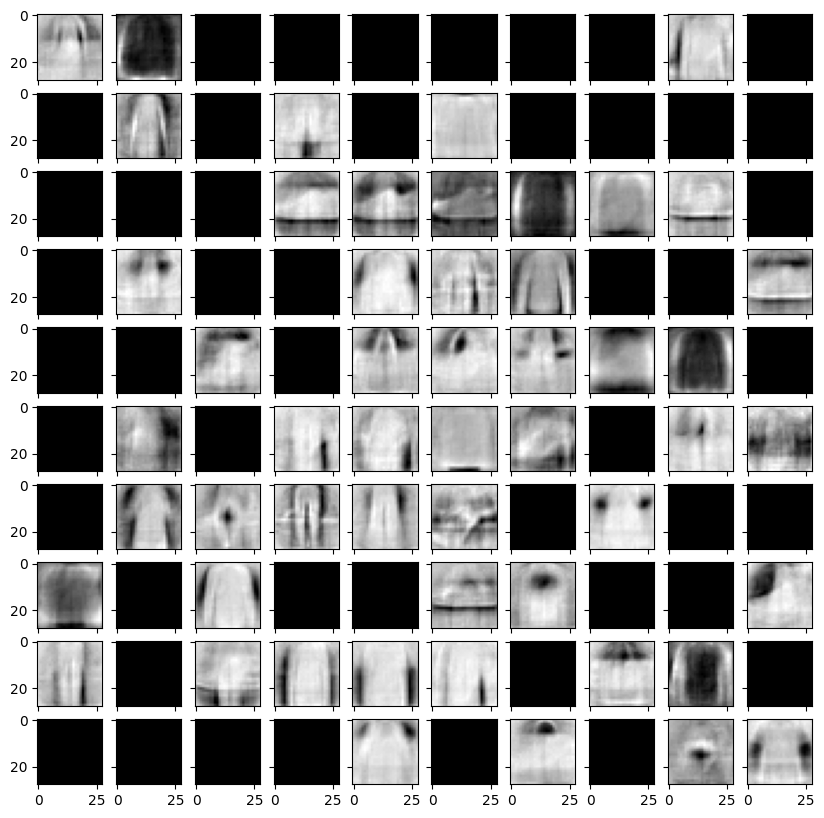

In [17]:
# Plot the receptive field of the third hidden layer:
w1 = get_weights(dbn_fmnist, layer=0)
w2 = get_weights(dbn_fmnist, layer=1)
w3 = get_weights(dbn_fmnist, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

# The result suggest that the 3rd layer could be generating a more complex representation of the input data

As it can be seen, the first layer of the network extracts simple features such as the edges of the clothes. The second layer builds on these features and captures more complex aspects of the clothes. The third layer shows a similar pattern, but also has some weak receptive fields that may be redundant, since other neurons in the network may have already learned the information that they are supposed to learn. This suggests that reducing the number of neurons in the last layer could be a good approach (simplify the network given that there are neurons not being used)


### Clustering internal representations

We can also examine the properties of the learned *distributed* representations. For example, we can compute the centroid of the representations learned for each class, and see how close they are to each other using a standard hierarchical clustering algorithm.

This implementation of the `DBN` contains internally several `RBM` objects. Therefore, we will need to compute the hidden representation using the weights of each `RBM`.

In [18]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fmnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

The representations computed for the second hidden layer are derived using the ones of the first hidden layer:

In [19]:
hidden_repr_1 = get_kth_layer_repr(fmnist_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)

torch.Size([60000, 400])


Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [20]:
def get_mask(label):  # we use this function to filter by class
  labels = fmnist_tr.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [21]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)  # Focus on third hidden layer

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [22]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

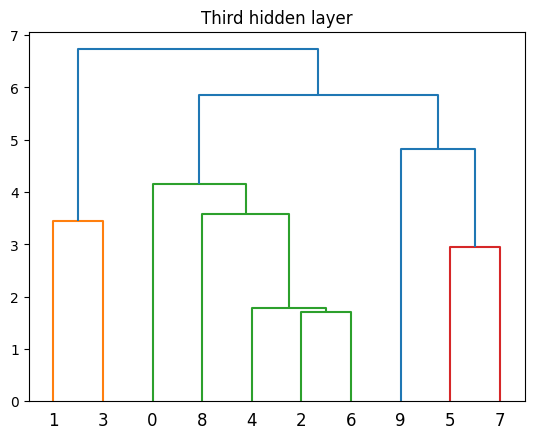

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

From this plot we can highlight the following:

- Classes 2 and 6 are similar. This two classes are similar to class 4. This makes sense since Pullovers, Shirts, and Coats share evident commonalities which are captured by the network
- Classes 5 and 7 are similar. This two classes are similar to class 9. This makes sense since Sandals, Sneakers, and Ankle boots share evident commonalities which are captured by the network

### Linear read-out

Another technique to analyze distributed representations is to decode them using a linear readout (as for the clustering, this can be done at each layer of the DBN). We will thus use the hidden representations to classify the FashionMNIST images as a way to assess how much information is contained in each hidden representation.
Let's first define the class for the classifier:

In [33]:
class LinearModel(torch.nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(layer_size, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.fc4 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Then, we can instantiate a linear classifier for each hidden layer of the DBN:

In [34]:
layer_size = dbn_fmnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_fmnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_fmnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Then, we train the linear classifiers on the hidden representations from each layer using the actual labels of the FashionMNIST dataset as targets:

In [35]:
def train_supervised(network, input_data, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.2)   # Stochastic Gradient Descent
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input_data).squeeze()
    targets = fmnist_tr.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:   # This is for diagnostic
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [36]:
train_supervised(linear1, hidden_repr_1, epochs = 3000)

epoch :   1/3000, loss = 2.3034
epoch : 101/3000, loss = 0.8609
epoch : 201/3000, loss = 0.5332
epoch : 301/3000, loss = 0.4284
epoch : 401/3000, loss = 0.3857
epoch : 501/3000, loss = 0.3659
epoch : 601/3000, loss = 0.3448
epoch : 701/3000, loss = 0.3350
epoch : 801/3000, loss = 0.3258
epoch : 901/3000, loss = 0.3222
epoch : 1001/3000, loss = 0.3069
epoch : 1101/3000, loss = 0.3103
epoch : 1201/3000, loss = 0.3003
epoch : 1301/3000, loss = 0.3075
epoch : 1401/3000, loss = 0.3005
epoch : 1501/3000, loss = 0.2768
epoch : 1601/3000, loss = 0.2757
epoch : 1701/3000, loss = 0.2758
epoch : 1801/3000, loss = 0.2960
epoch : 1901/3000, loss = 0.2641
epoch : 2001/3000, loss = 0.2570
epoch : 2101/3000, loss = 0.2710
epoch : 2201/3000, loss = 0.2648
epoch : 2301/3000, loss = 0.2470
epoch : 2401/3000, loss = 0.2448
epoch : 2501/3000, loss = 0.2480
epoch : 2601/3000, loss = 0.2411
epoch : 2701/3000, loss = 0.2351
epoch : 2801/3000, loss = 0.2339
epoch : 2901/3000, loss = 0.2201


In [37]:
train_supervised(linear2, hidden_repr_2, epochs = 3000)

epoch :   1/3000, loss = 2.3037
epoch : 101/3000, loss = 0.7103
epoch : 201/3000, loss = 0.5044
epoch : 301/3000, loss = 0.4154
epoch : 401/3000, loss = 0.3766
epoch : 501/3000, loss = 0.3562
epoch : 601/3000, loss = 0.3461
epoch : 701/3000, loss = 0.3296
epoch : 801/3000, loss = 0.3423
epoch : 901/3000, loss = 0.3146
epoch : 1001/3000, loss = 0.3136
epoch : 1101/3000, loss = 0.3161
epoch : 1201/3000, loss = 0.3070
epoch : 1301/3000, loss = 0.2962
epoch : 1401/3000, loss = 0.2918
epoch : 1501/3000, loss = 0.3064
epoch : 1601/3000, loss = 0.2777
epoch : 1701/3000, loss = 0.2864
epoch : 1801/3000, loss = 0.2749
epoch : 1901/3000, loss = 0.2661
epoch : 2001/3000, loss = 0.2692
epoch : 2101/3000, loss = 0.2773
epoch : 2201/3000, loss = 0.2603
epoch : 2301/3000, loss = 0.2707
epoch : 2401/3000, loss = 0.2742
epoch : 2501/3000, loss = 0.2699
epoch : 2601/3000, loss = 0.2436
epoch : 2701/3000, loss = 0.2479
epoch : 2801/3000, loss = 0.2512
epoch : 2901/3000, loss = 0.2458


In [38]:
train_supervised(linear3, hidden_repr_3, epochs = 3000)

epoch :   1/3000, loss = 2.3038
epoch : 101/3000, loss = 0.7835
epoch : 201/3000, loss = 0.5141
epoch : 301/3000, loss = 0.4229
epoch : 401/3000, loss = 0.3936
epoch : 501/3000, loss = 0.3679
epoch : 601/3000, loss = 0.3564
epoch : 701/3000, loss = 0.3459
epoch : 801/3000, loss = 0.3356
epoch : 901/3000, loss = 0.3289
epoch : 1001/3000, loss = 0.3248
epoch : 1101/3000, loss = 0.3165
epoch : 1201/3000, loss = 0.3083
epoch : 1301/3000, loss = 0.3049
epoch : 1401/3000, loss = 0.3128
epoch : 1501/3000, loss = 0.3037
epoch : 1601/3000, loss = 0.2926
epoch : 1701/3000, loss = 0.2985
epoch : 1801/3000, loss = 0.2909
epoch : 1901/3000, loss = 0.2886
epoch : 2001/3000, loss = 0.2815
epoch : 2101/3000, loss = 0.2840
epoch : 2201/3000, loss = 0.2863
epoch : 2301/3000, loss = 0.2824
epoch : 2401/3000, loss = 0.2817
epoch : 2501/3000, loss = 0.2656
epoch : 2601/3000, loss = 0.2728
epoch : 2701/3000, loss = 0.2657
epoch : 2801/3000, loss = 0.2705
epoch : 2901/3000, loss = 0.2649


Let's now evaluate the trained readouts using the hidden representations computed on the *test* set:

In [39]:
# Test linear decoders:
# Project each test data to the hidden layers
hidden_repr_1_test = get_kth_layer_repr(fmnist_te.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [40]:
# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

Finally, let's compute the accuracy scores:

In [41]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [42]:
compute_accuracy(predictions_test1, fmnist_te.targets)

0.8770999908447266

In [43]:
compute_accuracy(predictions_test2, fmnist_te.targets)

0.8655999898910522

In [44]:
compute_accuracy(predictions_test3, fmnist_te.targets)

0.8756999969482422

Different architectures were evaluated by changing the original formulation seen in the labs to the following ones. The accuracy is reported for each layer:

- Linear layer, 3000 epoch, learning rate 0.2:
  - Test1 : 0.8610999584197998
  - Test2 : 0.8646000027656555
  - Test3 : 0.8596000075340271

- Linear layer, 3000 epoch, learning rate 0.05:
  - Test1 : 0.84579998254776
  - Test2 : 0.8502999544143677
  - Test3 : 0.8470999598503113

- Two fully connected layers (128 - 10) with ReLU activation function applied after the first layer, 3000 epoch, learning rate 0.05:
  - Test1 : 0.8588999509811401
  - Test2 : 0.8619999885559082
  - Test3 : 0.856499969959259

- Three fully connected layers (128 - 64 - 10) with ReLU activation function applied after the first layer, 3000 epoch, learning rate 0.05:
  - Test1 : 0.866599977016449
  - Test2 : 0.8671999573707581
  - Test3 : 0.8634999990463257

- Four fully connected layers (256 - 128 - 64 - 10) with ReLU activation function for the output layer, applied after the first layer, 3000 epoch, learning rate 0.05:
  - Test1 : 0.8680999875068665
  - Test2 : 0.8675999641418457
  - Test3 : 0.8619999885559082

- Four fully connected layers (256 - 128 - 64 - 10) with ReLU activation function for the output layer, applied after the first layer, 3000 epoch, learning rate 0.05, Adam optimizer:
  - Test1 : 0.8542999625205994
  - Test2 : 0.8693999648094177
  - Test3 : 0.861299991607666

- Four fully connected layers (256 - 128 - 64 - 10) with ReLU activation function for the output layer, applied after the first layer, 3000 epoch, learning rate 0.2:
  - Test1 : 0.8770999908447266
  - Test2 : 0.8655999898910522
  - Test3 : 0.8756999969482422

One can observe that the highest performance scores are achieved by the last architecture discussed. However, the improvement in accuracy is slight, so a simpler model like the first one may be preferable from a parsimony perspective.

### Confusion matrices

In this section, the confusion matrices are computed using the test targets and the predictions from the linear readout


#### Layer 1

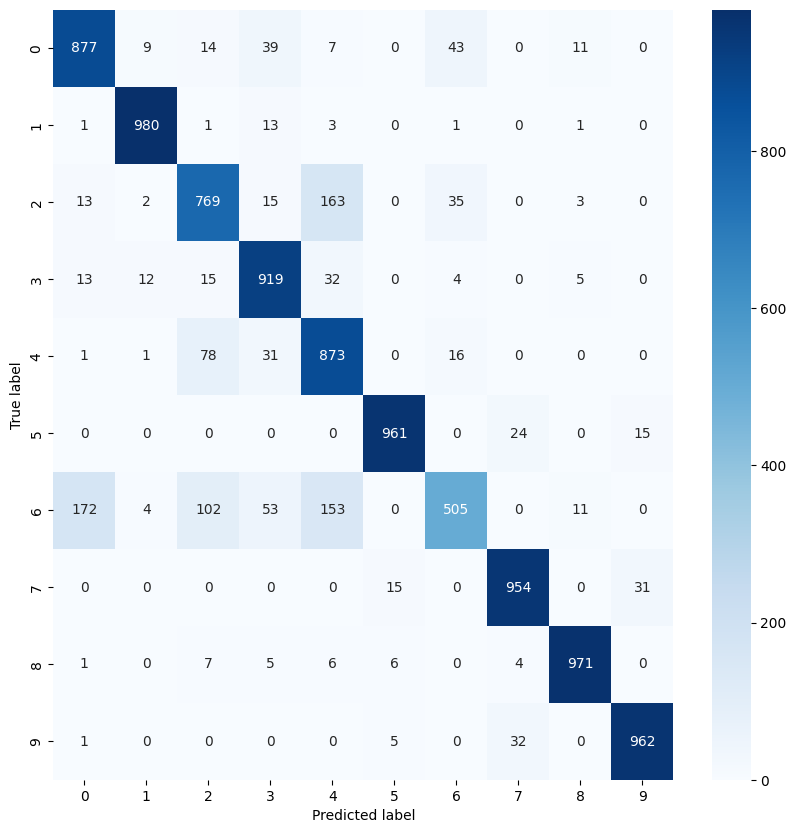

In [48]:
cm = confusion_matrix(fmnist_te.targets.cpu().numpy(), np.argmax(predictions_test1.cpu().detach().numpy(),axis=1))

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In this matrix related to the first layer, it is possible to notice that class 6 (Shirts) is the one that presents the most number of missclassified examples. In particular, the top 3 in descending order are class 0 (T-shirt/top), 4 (Coat), and 2 (Pullover). These can be seen as clothes from the same family as they share some similarities, and thus it could be said that the first layer has not learned the features needed to distinguish the differences between them


#### Layer 2

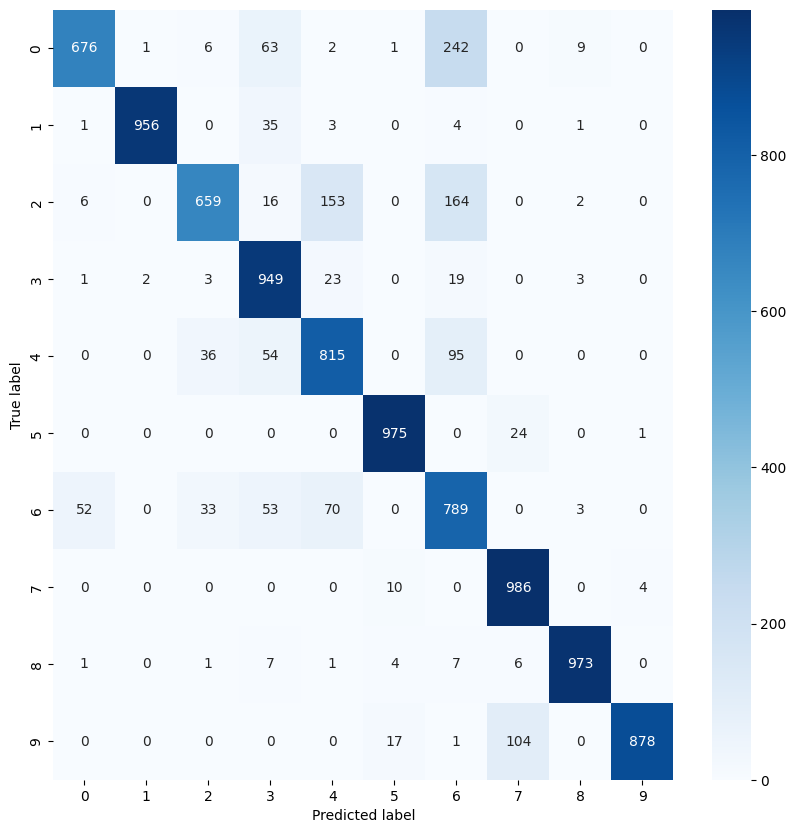

In [46]:
cm = confusion_matrix(fmnist_te.targets.cpu().numpy(), np.argmax(predictions_test2.cpu().detach().numpy(),axis=1))

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

The matrix for the second layer shows that class 6 (Shirts) has a better prediction performance for the classes that were hard to separate in the first layer, likely because of the higher-level features that are extracted. However, the misclassification rates for classes 0 and 2 increased, which may indicate that the features learned in this layer are not sufficient to discriminate between those classes.

#### Layer 3

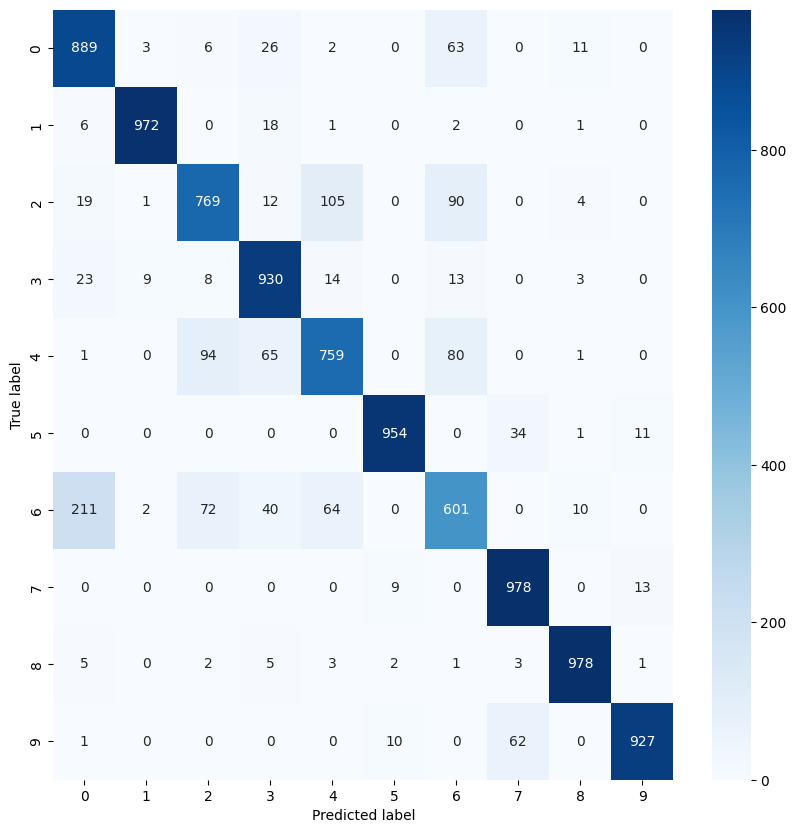

In [47]:
cm = confusion_matrix(fmnist_te.targets.cpu().numpy(), np.argmax(predictions_test3.cpu().detach().numpy(),axis=1))

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Finally, in this matrix related to the third layer, it is possible to notice that class 6 (Shirts) again causes the most number of misclassified examples by not being able to distinguish them from class 0 (T-shirt/top)

### Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the DBN are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

In [50]:
def inject_noise(fmnist_data, noise_level):
  random_gaussian_tensor = torch.randn(fmnist_data.shape, device = device) * noise_level
  # We could clip these valus between 0 and 1.
  return fmnist_data + random_gaussian_tensor

Plotting a noisy image

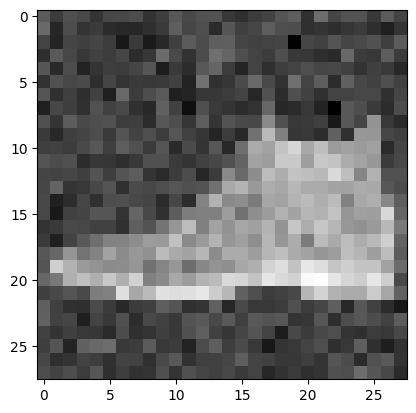

In [54]:
noise_level = 0.1
fmnist_test_with_noise = inject_noise(fmnist_te.data, noise_level)
__ = plt.imshow(fmnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

We will now compute the hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy stimuli.

In [55]:
def get_accuracy_values_at_noise_level(noise_level):

  fmnist_test_with_noise = inject_noise(fmnist_te.data, noise_level)  # first, let's create noisy test images

  hidden_repr_1_noisy = get_kth_layer_repr(fmnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, fmnist_te.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, fmnist_te.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, fmnist_te.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden

In [56]:
# We could get curves with this, based on noise level:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])

Accuracy of H1 read-out: 0.807
Accuracy of H2 read-out: 0.826
Accuracy of H3 read-out: 0.843


Let's create the psychometric curves for the DBN (at different levels of internal representations)

In [57]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden"])

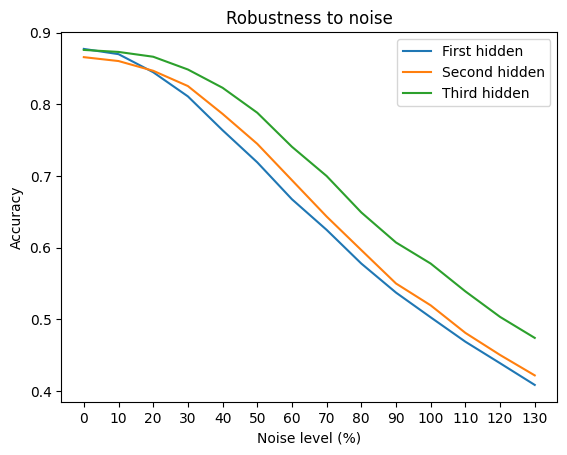

In [58]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

In this plot, it can be seen that the robustness of each hidden layer increases as noise is injected. This happens because lower layers capture basic features and are more sensitive to noise, while higher layers learn to extract more robust and invariant features that are less affected by noise

### Perturbing the model with adversarial attacks

#### Fast gradient sign *method*

Reference: https://jaketae.github.io/study/fgsm/

In general, with adversarial attacks we try to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the model's parameters, the input data and the output targets: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure:
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like (epsilon is small, in order to perturb the input just a little bit):

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

The goal here is to misclassify the input (in more advanced method, the goal could be to misclassify some class or classes)

In [59]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

### Adversarial samples

We need to define a unified architecture incorporating the DBN + readout layers, which allows to compute the gradient of the loss (classification task) with respect to the input data that is being processed.

In [60]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_fmnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_fmnist = dbn_fmnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_fmnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM activations
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_fmnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [61]:
dbn_with_readout = DBNWithReadOut(dbn_fmnist, [linear1, linear2, linear3], readout_level=2)

Let's see what an adversarial sample looks like. Let's take one sample from the test set:

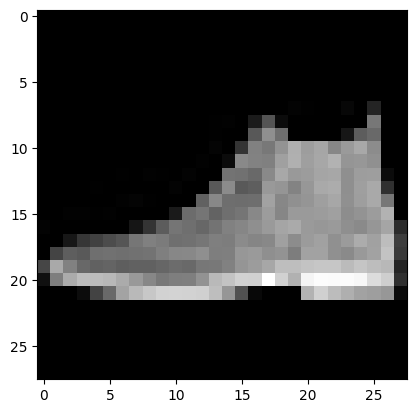

In [68]:
test_sample_idx = 0
test_image = fmnist_te.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'), cmap = "gray")

Let's classify this "clean" image using one of the models we previously trained and then modify the image to attack the network.

In [69]:
attacked_model = dbn_with_readout

In [70]:
test_image.requires_grad_()  # store the gradients of the pixels
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 9.


Let's create and visualize the corresponding adversarial sample.
The function `loss.backward()` computes the gradient for every parameter that was activated using the call `requires_grad=True`.

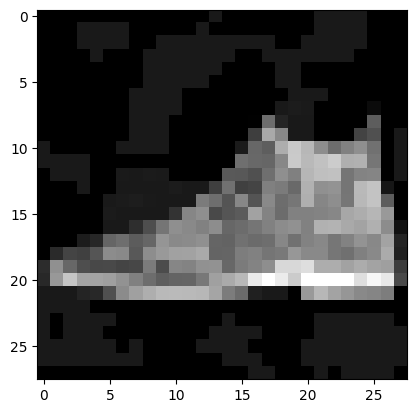

In [86]:
epsilon = 0.1  # define strenght of the attack
test_image_label = fmnist_te.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss

# Create adversarial attack using the function defined before
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

# Send the data back to the CPU and detach it from the computation graph
perturbed_image_np = perturbed_image.detach().to("cpu").numpy()

# Show the resulting image
__ = plt.imshow(perturbed_image_np.reshape(28,28), cmap = "gray")

In [87]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 7.


With an $\epsilon >= 0.016 $ this example is already misclassified as class 7 (Sneaker) instead of Ankle boot

### Resisting to adversarial attacks

Let's now compare the ability to resist to adversarial attacks of the DBN.

We will also test its ability to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation.

In [88]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    # num_steps = 0 implies that we are not defending
    correct = 0
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, print the result

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # we need to get the gradient to perform the attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)   # This loss is going to be maximized by the attack
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_fmnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [89]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=True, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15803779.62it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269450.85it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5009300.15it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5781064.79it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Let's now compare compare with the read-out trained on the hidden representations of the DBN:

In [104]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 34.64%



And finally let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



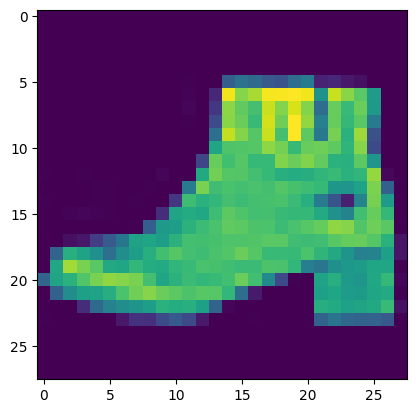


Here's a perturbed sample:



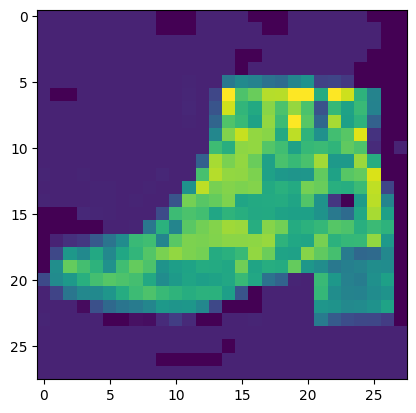


Here's what a 3-steps reconstructed sample looks like:



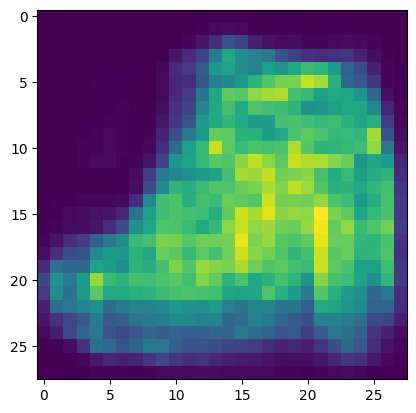


Epsilon: 0.1
Test Accuracy: 36.85%



In [109]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=3)

The top-down reconstruction step was applied three times with $\epsilon = 0.1$ to test its effect on the accuracy. The results showed a slight improvement of 2 percentage points, but this was not significant. This suggests that the network could not remove the adversarial perturbations from the input, and the output image was still far from the original one.

### Effect of the noise parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [115]:
epsilon_values = [0, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [116]:
%%capture
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=3)

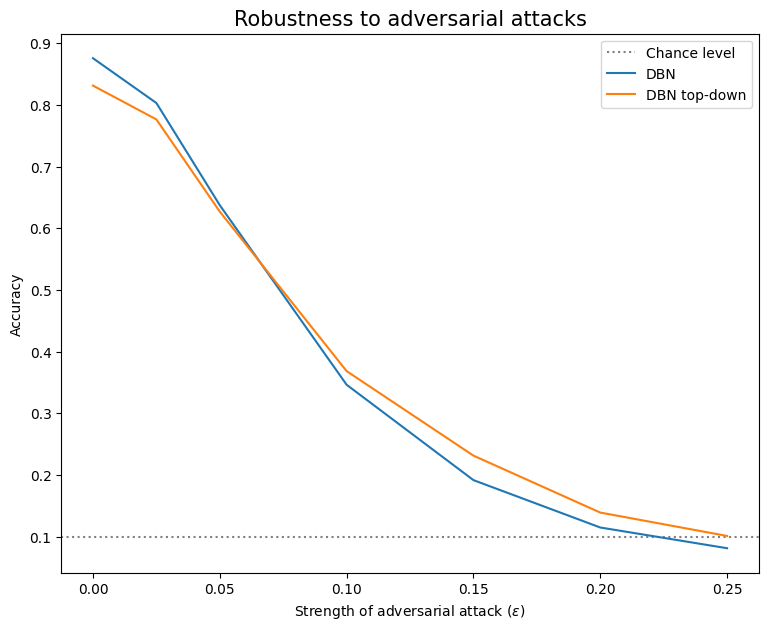

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "DBN", "DBN top-down"])

The plot shows how the DBN and DBN top-down method differ in their accuracies. The top-down reconstruction process improves the accuracy by about 5 percentage points after a certain $\epsilon$ value, indicating that this method can improve the response to adversarial attacks.

### Conclusion

This project explored DBNs using the Fashion MNIST dataset, aiming to understand their workings and test their resilience to adversarial attacks. Different network architectures were evaluated, with more complex models showing slight accuracy improvements but not significantly outperforming simpler ones.

Analysis of confusion matrices revealed the network's ability to discriminate between classes at different layers, with deeper layers capturing higher-level features. Additionally, the network demonstrated increased robustness to noise, with deeper layers being more resilient.

When subjected to adversarial attacks, the top-down reconstruction process slightly improved accuracy but couldn't fully remove perturbations. However, it did enhance the network's response to attacks.